Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 9 Normal files and 22 Failure files.
Final Dataset Shape: (57464, 5)


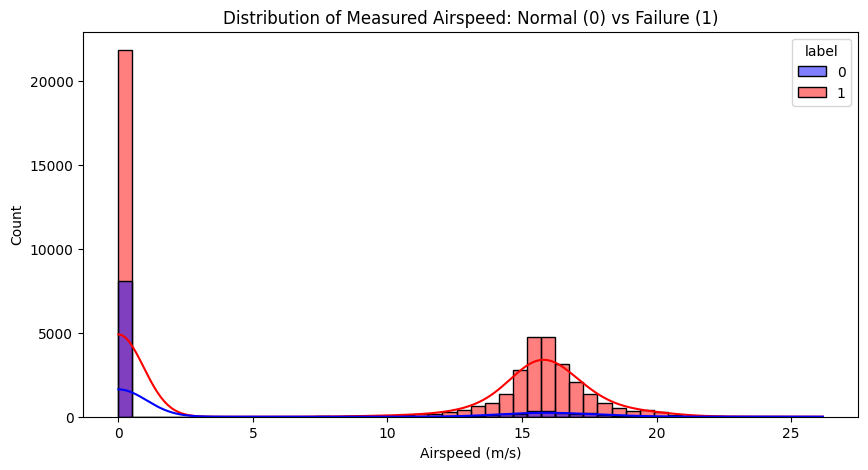

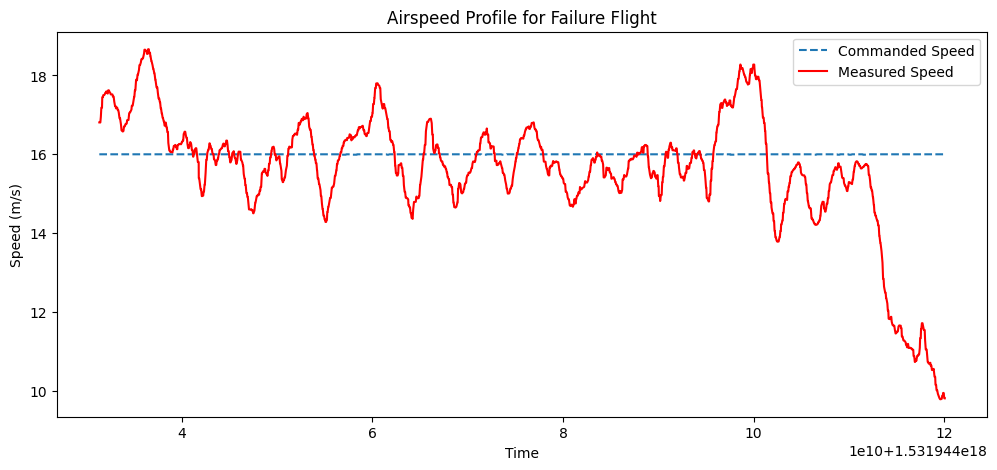

Training Models...

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.47      0.64      2524
           1       0.90      1.00      0.95     11842

    accuracy                           0.91     14366
   macro avg       0.94      0.74      0.79     14366
weighted avg       0.91      0.91      0.89     14366


--- SVM (RBF) ---
              precision    recall  f1-score   support

           0       0.98      0.47      0.64      2524
           1       0.90      1.00      0.95     11842

    accuracy                           0.91     14366
   macro avg       0.94      0.74      0.79     14366
weighted avg       0.91      0.91      0.89     14366


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.92      0.58      0.71      2524
           1       0.92      0.99      0.95     11842

    accuracy                           0.92     14366
   macro avg       0.92      0.78     

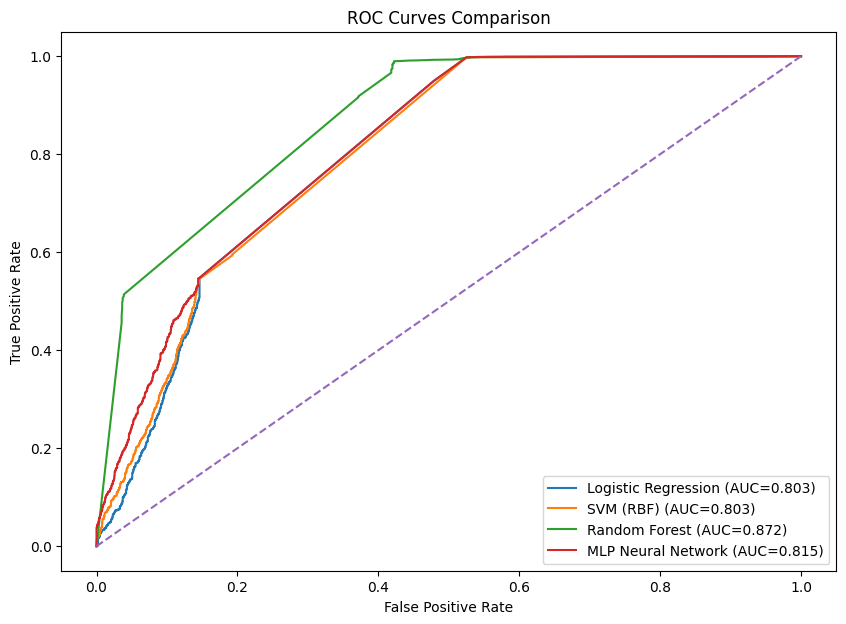

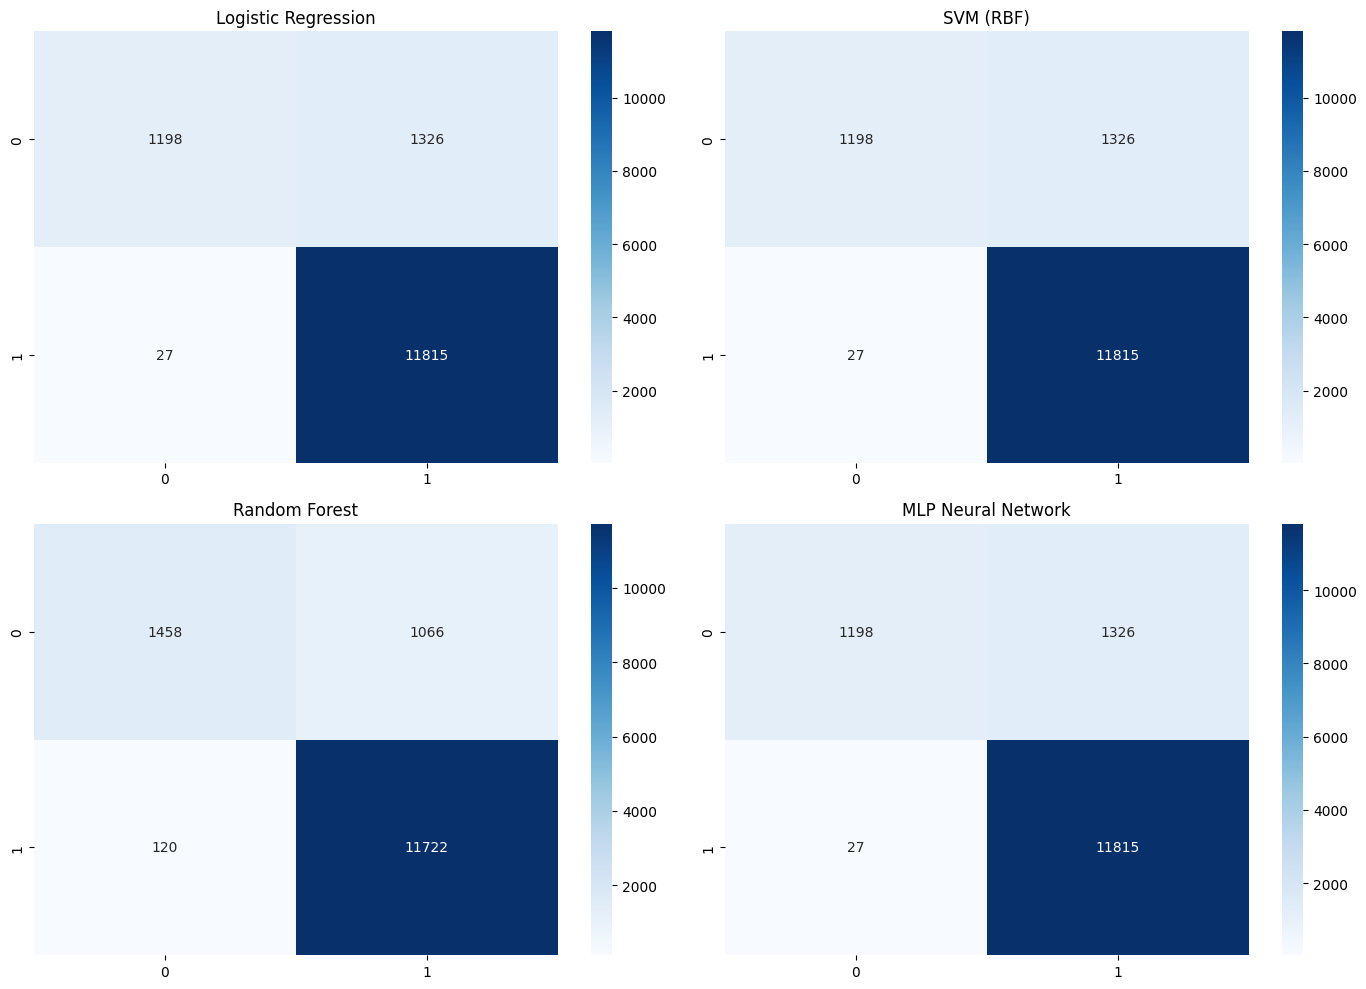

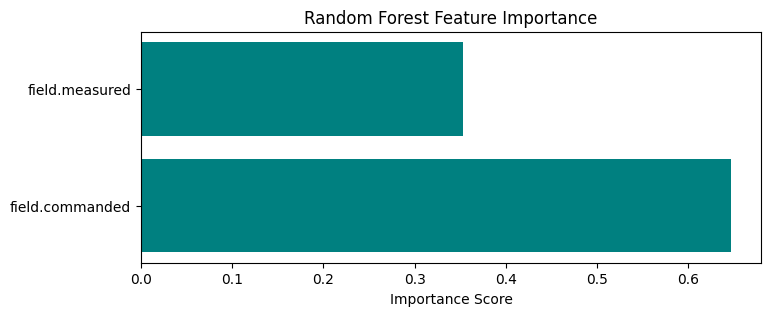

Interpretation: The model relies 35.26% on 'Measured Airspeed'.
This confirms the model is detecting physical anomalies, not just memorizing commands.


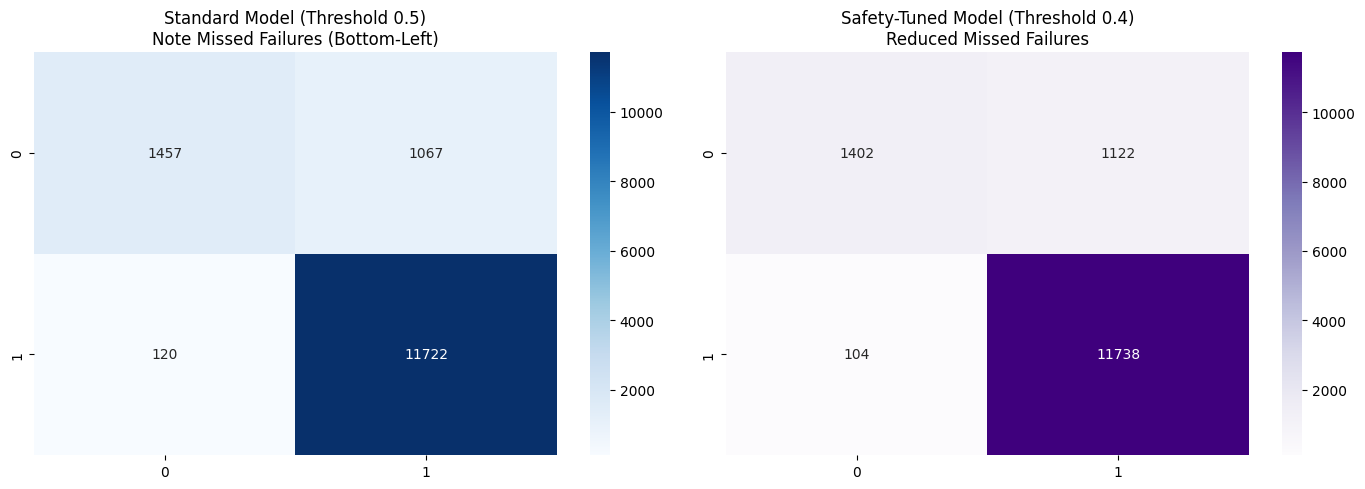

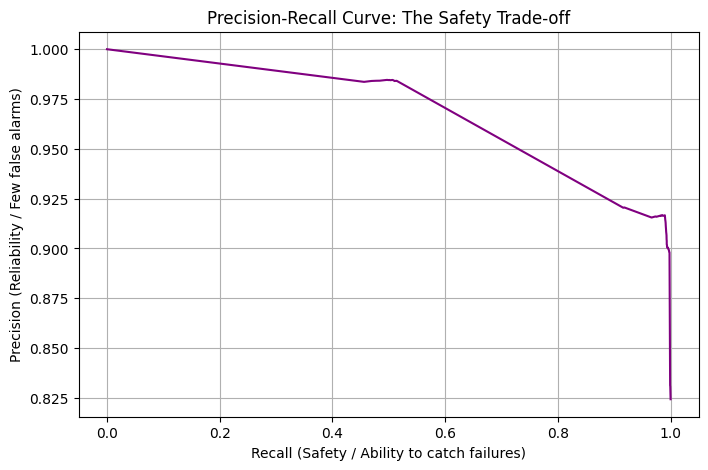

Project Complete


In [4]:
# =============================================================================
# PROJECT: UAV Engine Failure Detection
# AUTHOR: Shruti SHARMA
# DESCRIPTION:
# This project uses Machine Learning to detect engine failures in Unmanned
# Aerial Vehicles (UAVs) using airspeed sensor data. It compares four
# supervised learning models and implements a safety-critical decision system.
# =============================================================================

# --- 1. LIBRARIES & SETUP ---
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Preprocessing & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Mount Google Drive to access the ALFA Dataset
from google.colab import drive
drive.mount('/content/drive')

# Path to the processed data
DATASET_PATH = "/content/drive/MyDrive/uav_project/data/alfa-dataset/processed"


# --- 2. DATA LOADING & PROCESSING ---
# We load CSV logs identifying "Normal" flights vs "Engine Failure" flights.
# The goal is to merge them into a single dataframe for training.

normal_files = glob.glob(f"{DATASET_PATH}/**/*no_failure*airspeed*.csv", recursive=True)
failure_files = glob.glob(f"{DATASET_PATH}/**/*engine_failure*airspeed*.csv", recursive=True)

print(f"Loaded {len(normal_files)} Normal files and {len(failure_files)} Failure files.")

def load_airspeed_csv(path, label):
    """
    Reads a flight log CSV and extracts relevant airspeed features.

    Args:
    - path: File path to the CSV
    - label: 0 for Normal, 1 for Failure

    Returns: DataFrame with selected columns and target label
    """
    df = pd.read_csv(path)
    # We select only the Command (Pilot Input) and Measured (Sensor Reading) airspeed
    df = df[columns_to_keep := ["%time", "field.commanded", "field.measured"]]
    df["label"] = label
    df["flight_id"] = os.path.basename(path)
    return df

# Combine all files into one dataset
dfs = [load_airspeed_csv(f, 0) for f in normal_files] + [load_airspeed_csv(f, 1) for f in failure_files]
data = pd.concat(dfs, ignore_index=True)

print(f"Final Dataset Shape: {data.shape}")


# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
# Requirement: Explore data structure and patterns before modeling.

# A. Histogram: Measured Airspeed Distribution
# We visualize how airspeed differs during normal flight vs failure.
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="field.measured", hue="label", kde=True, bins=50, palette=['blue', 'red'])
plt.title("Distribution of Measured Airspeed: Normal (0) vs Failure (1)")
plt.xlabel("Airspeed (m/s)")
plt.show()

# B. Time-Series: Visualizing a single Failure Flight
# Plotting commanded vs measured airspeed for a specific crash scenario.
if len(failure_files) > 0:
    failure_id = failure_files[0].split('/')[-1]
    flight_data = data[data['flight_id'] == failure_id]

    plt.figure(figsize=(12, 5))
    plt.plot(flight_data['%time'], flight_data['field.commanded'], label='Commanded Speed', linestyle='--')
    plt.plot(flight_data['%time'], flight_data['field.measured'], label='Measured Speed', color='red')
    plt.title(f"Airspeed Profile for Failure Flight")
    plt.xlabel("Time")
    plt.ylabel("Speed (m/s)")
    plt.legend()
    plt.show()


# --- 4. PREPROCESSING ---
# Preparing data for machine learning algorithms.

X = data[["field.commanded", "field.measured"]]
y = data["label"]

# Scaling: Essential for SVM and Neural Networks to converge faster.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split: 75% for training, 25% for final evaluation.
# Stratify ensures the ratio of failures is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)


# --- 5. MODEL TRAINING & COMPARISON ---
# Training four different classifiers to find the best fit.

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM (RBF)": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=120, random_state=42),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(32,16), max_iter=500, random_state=42)
}

results = {}
y_probs = {}

print("Training Models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    # Store results for later comparison
    y_probs[name] = y_prob
    results[name] = classification_report(y_test, y_pred, output_dict=True)

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))


# --- 6. MODEL EVALUATION & VISUALIZATION ---
# A. ROC Curves: Comparing ability to distinguish classes
plt.figure(figsize=(10, 7))
for name in models:
    fpr, tpr, _ = roc_curve(y_test, y_probs[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# B. Confusion Matrices: Visualizing errors
plt.figure(figsize=(14,10))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(2,2,i+1)
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(name)
plt.tight_layout()
plt.show()


# --- 7. MODEL INTERPRETATION (Explainability) ---
# Requirement: Explain WHY the model makes decisions.
# We interpret the Random Forest model as it was the top performer.

rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = ["field.commanded", "field.measured"]

plt.figure(figsize=(8, 3))
plt.barh(feature_names, importances, color='teal')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()

print(f"Interpretation: The model relies {importances[1]:.2%} on 'Measured Airspeed'.")
print("This confirms the model is detecting physical anomalies, not just memorizing commands.")


# --- 8. DECISION SUPPORT SYSTEM (Safety Threshold) ---
# Requirement: Derive actionable recommendations.
# Strategy: Adjust decision threshold to prioritize Safety (Recall) over Precision.

# Get probability scores from Random Forest
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Safety Threshold: Lowering from 0.50 to 0.40 to catch edge-case failures.
# Logic: It is safer to have a false alarm than a missed engine failure.
safety_threshold = 0.4
y_pred_safe = (y_scores >= safety_threshold).astype(int)

# Visual Proof: Confusion Matrix Comparison
y_pred_standard = (y_scores >= 0.5).astype(int)
cm_standard = confusion_matrix(y_test, y_pred_standard)
cm_safe = confusion_matrix(y_test, y_pred_safe)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_standard, annot=True, cmap="Blues", fmt="d", ax=axes[0])
axes[0].set_title("Standard Model (Threshold 0.5)\nNote Missed Failures (Bottom-Left)")

sns.heatmap(cm_safe, annot=True, cmap="Purples", fmt="d", ax=axes[1])
axes[1].set_title("Safety-Tuned Model (Threshold 0.4)\nReduced Missed Failures")
plt.tight_layout()
plt.show()

# Plot Precision-Recall Trade-off
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='purple')
plt.title('Precision-Recall Curve: The Safety Trade-off')
plt.xlabel('Recall (Safety / Ability to catch failures)')
plt.ylabel('Precision (Reliability / Few false alarms)')
plt.grid()
plt.show()


print("Project Complete")
